In [1]:
import torch
import requests
import numpy as np
from PIL import Image
from io import BytesIO
import torchvision.transforms as T
from torch.nn.functional import mse_loss, l1_loss
from movqgan import get_movqgan_model

In [2]:
model = get_movqgan_model('270M', pretrained=True, device='cuda')

Working with z of shape (1, 4, 32, 32) = 4096 dimensions.


/home/jovyan/.imgenv-maltseva-test3-0/lib/python3.7/site-packages/huggingface_hub/file_download.py:654: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  FutureWarning,


In [3]:
def show_images(batch, return_image=False):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(torch.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    if return_image:
        return Image.fromarray(reshaped.numpy())
    display(Image.fromarray(reshaped.numpy()))

In [4]:
def prepare_image(img):
    """ Transform and normalize PIL Image to tensor. """
    transform = T.Compose([
            T.RandomResizedCrop(512, scale=(1., 1.), ratio=(1., 1.), interpolation=T.InterpolationMode.BICUBIC),
        ])
    pil_image = transform(img)
    arr = np.array(pil_image.convert("RGB"))
    arr = arr.astype(np.float32) / 127.5 - 1
    return torch.from_numpy(np.transpose(arr, [2, 0, 1]))

In [5]:
url = "https://look.com.ua/pic/201609/1024x768/look.com.ua-177244.jpg"
response = requests.get(url)
img = prepare_image(Image.open(BytesIO(response.content)))

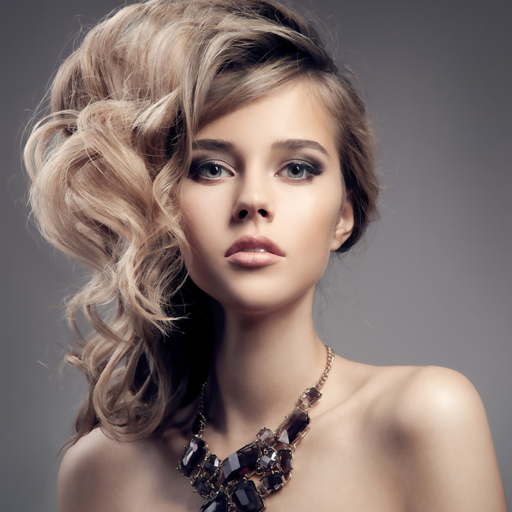

In [6]:
# Input
show_images(img.unsqueeze(0))

In [7]:
%%time
with torch.no_grad():
    out = model(img.to('cuda').unsqueeze(0))[0]

CPU times: user 97.6 ms, sys: 21.5 ms, total: 119 ms
Wall time: 119 ms


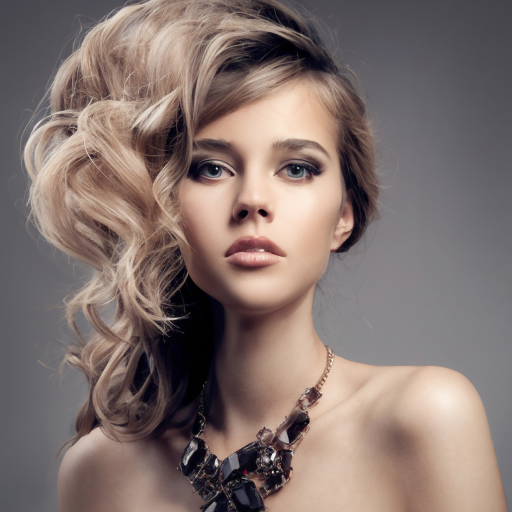

mse = 0.0034 l1 = 0.0323


In [8]:
# Output
show_images(out)
mse = mse_loss(out, img.to('cuda').unsqueeze(0))
l1 = l1_loss(out, img.to('cuda').unsqueeze(0))
print('mse =', np.round(mse.item(),4), 'l1 =', np.round(l1.item(),4))

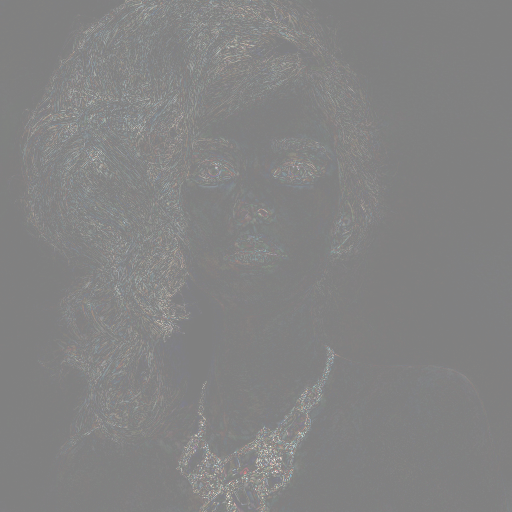

In [9]:
# absolute difference between input and output
show_images(torch.abs(out - img.to('cuda').unsqueeze(0)))